In [1]:
# Importing important libraries.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('seaborn')

In [3]:
data = pd.read_csv('Hypertention.csv',sep=';')
print(f'Dataset Shape: {data.shape}')

Dataset Shape: (70000, 13)


Below are some of the key assumptions that we can make about the data and will look to validate them 
with the data in hand.
1. With the increase in age chances of heart disease increases.
2. Effect of height and weight. We assume that with more BMI chances of hypertension is more.
4. ap_hi > ap_lo. With the increaes of bp the chances of hypertension are more. Check if we have patients 
   with low bp but still have the disease.
5. With increase of cholesterol the chances of hypertension increases as per scientific tests.
6. Increase in blood glucose levels could be a cause of increased heart risk.
7. Check about how patient drinking and smoking habbits would increase the chances of heart risk. 
   Are drinking men/women more prone to having a heart disease ?
8. Physical Activity is assumed to help in lower cholesterol and thus lower chances of heart disease.

FEATURE ENGINEERING STEPS.
1. Use height and weight to calculate BMI of a patient and see if it has some impact on the target variable.
2. Combine smoking and alcohol as a single feature using feature interaction.
3. We can think of creating a feature based on age and gender of a person to check if he/she is more likely    to  have diseased.

EDA 
1. Mens below 65 are more prone to be hypertensive than women. However, above 65 both of them share a almost common rate.
2. Normal blood pressure range is 120/80 for ap_hi/ap_lo respectively. Check if we are having a heart diseased person with low bp. 
3. Cholesterol, glucose and hi bp effect on patient health.

In [4]:
# Identifying missing values and duplicates first.
data.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [5]:
duplicates = len(data) - len(data.drop(['id'],axis=1).drop_duplicates())
data.drop(['id'],axis=1,inplace=True)
data.drop_duplicates(inplace=True)
print(f'{duplicates} duplicate records dropped.')

24 duplicate records dropped.


In [6]:
data.shape

(69976, 12)

From the above we can see that we do not have any missing values into our dataset and also have removed 24 duplicate records.

In [7]:
# Let us now begin first with finding some quick descriptive stats about our data.
print(f'{data.dtypes.value_counts()}')

int64      11
float64     1
dtype: int64


In [8]:
print('Let us now get a quick summary of features available.')
data.describe().T.round(2)

Let us now get a quick summary of features available.


,count,mean,std,min,25%,50%,75%,max
age,69976.0,19468.95,2467.37,10798.0,17664.0,19703.0,21327.0,23713.0
gender,69976.0,1.35,0.48,1.0,1.0,1.0,2.0,2.0
height,69976.0,164.36,8.21,55.0,159.0,165.0,170.0,250.0
weight,69976.0,74.21,14.40,10.0,65.0,72.0,82.0,200.0
ap_hi,69976.0,128.82,154.04,-150.0,120.0,120.0,140.0,16020.0
ap_lo,69976.0,96.64,188.50,-70.0,80.0,80.0,90.0,11000.0
cholesterol,69976.0,1.37,0.68,1.0,1.0,1.0,2.0,3.0
gluc,69976.0,1.23,0.57,1.0,1.0,1.0,1.0,3.0
smoke,69976.0,0.09,0.28,0.0,0.0,0.0,0.0,1.0
alco,69976.0,0.05,0.23,0.0,0.0,0.0,0.0,1.0


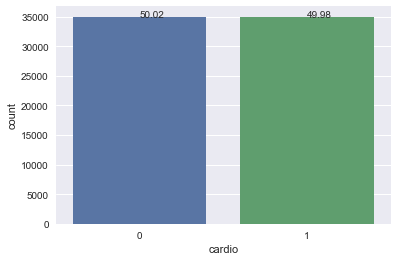

In [9]:
# Let us first have a look at our target variable.
fig, ax = plt.subplots(1,1)
sns.countplot(data['cardio'], ax = ax)
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2,height,'{:.2f}'.format((i.get_height()/len(data['cardio']))*100,'%'))
plt.show()

Wow. Looks like target variable is pretty balanced, so we need not to worry about class imbalance in our problem.


In [10]:
# Age is given in days. Transforming it into years for better understanding and checking relation with the target variable.
data['age'] = data['age']/365

No handles with labels found to put in legend.


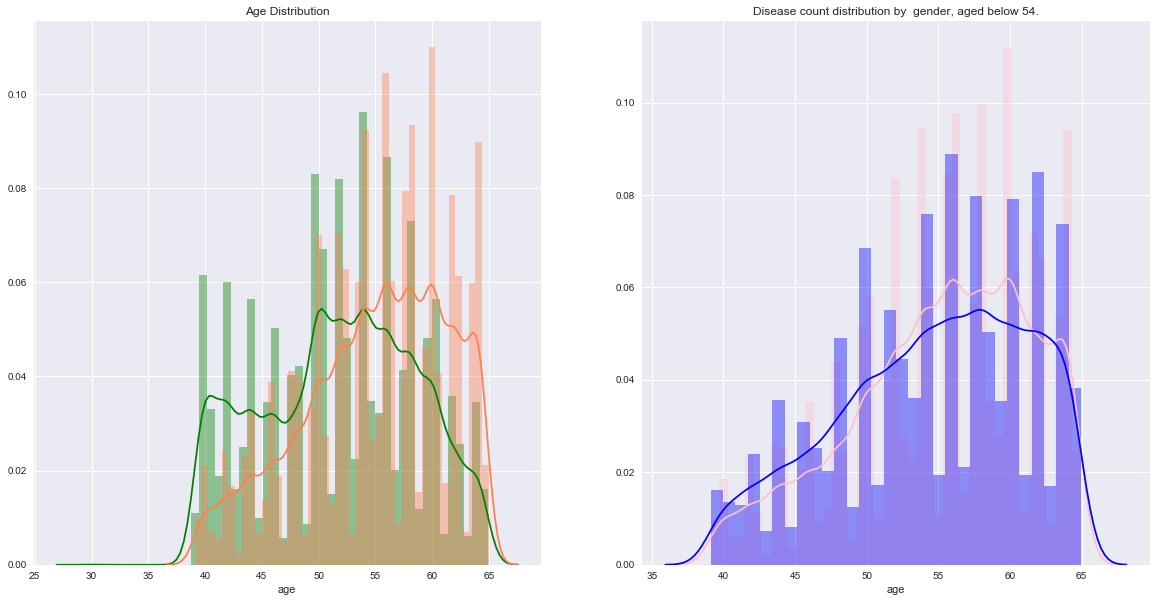

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
sns.distplot(data['age'][data['cardio']==0], ax = ax1, color='green')
sns.distplot(data['age'][data['cardio']==1], ax = ax1,color='coral')
ax1.set_title('Age Distribution')
ax1.legend()

sns.distplot(data['age'][(data['gender']==1) & (data['cardio']==1)],ax = ax2,color='pink')
sns.distplot(data['age'][(data['gender']==2) & (data['cardio']==1)],ax = ax2,color='blue')
ax2.set_title('Disease count distribution by  gender, aged below 54.')
plt.show()

People above the age of 54 are more likely to have diseased then below, also males below 50 are more likely to have been diagnosed with heart disease than females which confirms our assumption, even though the difference is not that drastic.

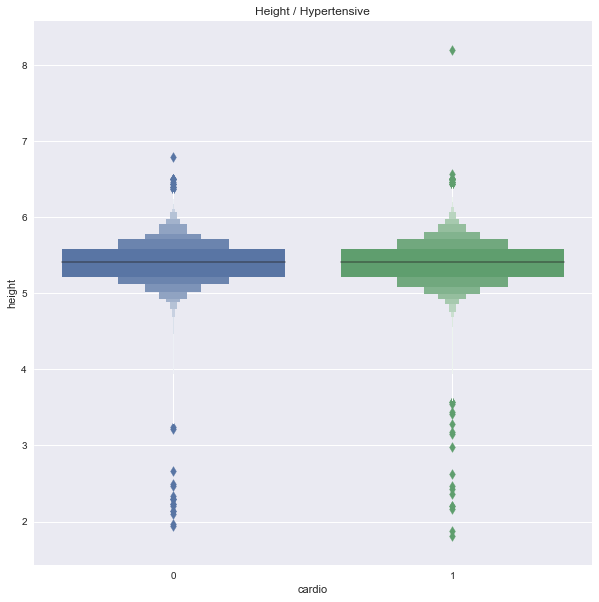

In [12]:
fig, (ax1) = plt.subplots(1,1, figsize=(10,10))
sns.boxenplot(data['cardio'],(data['height']*0.0328084),ax=ax1)
ax1.set_title('Height / Hypertensive')
plt.show()

From the above plot we can see that there are certain outliers in the feature.
For eg:
There are persons with more than 8 foot height which definitely looks and outlier 
Also, there are few with even less then 3 foot in height which could be children. 
To confirm this we need to check their weight and age and decide if they are outliers or could be a valid entry.


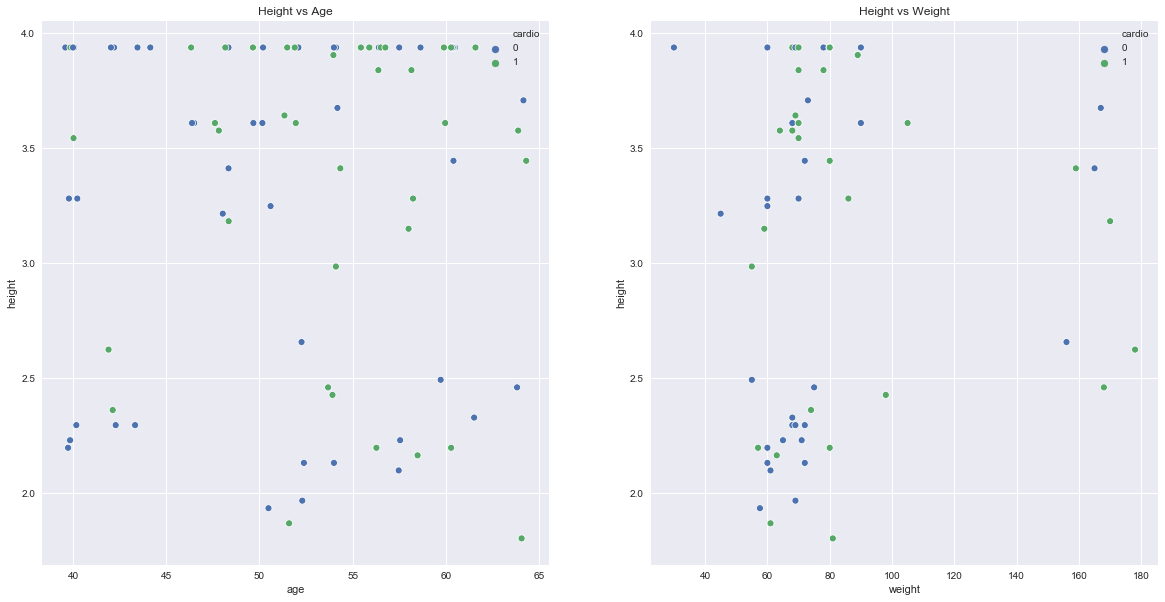

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(data['age'],data['height'][(data['height']*0.0328084)<4]*0.0328084,hue=data['cardio'],ax=ax1)
ax1.set_title('Height vs Age')
sns.scatterplot(data['weight'],data['height'][(data['height']*0.0328084)<4]*0.0328084,hue=data['cardio'],ax=ax2)
ax2.set_title('Height vs Weight')
plt.show()

From the above we can see that the people with below 4 foot in height are mostly aged above 40 and have a weight above 40kg mostly.
This definitely confirms that they are not children. Now for our analytical purposes we can delete such records from our data as they are hinting more towards outliers.

In [15]:
# Converting height in cms to foot.
data['height'] = data['height']*0.0328084 
filt =(data['height']>8) | (data['height']<3) 

data.drop(index = list(data[filt].index),inplace=True)
print(f'Dataset: {data.shape}')

Dataset: (69950, 12)


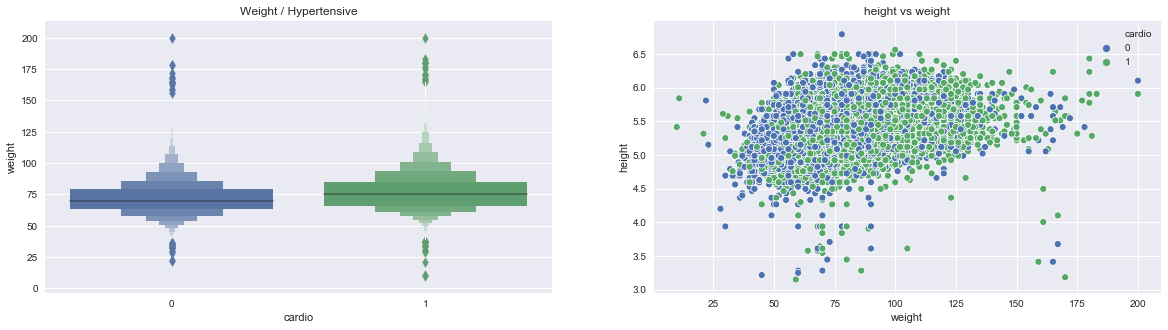

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
sns.boxenplot(data['cardio'],(data['weight']),ax=ax1)
ax1.set_title('Weight / Hypertensive')
sns.scatterplot(data['weight'],data['height'],ax=ax2,hue=data['cardio'])
ax2.set_title('height vs weight')
plt.show()

From the above plots we can see that there are persons with more than 155 kgs of weight with height less than 4.5 foot which seems like a bit abnormal.
Also, there are people with less than 25kg of weight and there are ones with more than 175 kg of weight which looks like an outlier to me.
We will eliminate all such records from our analysis.

In [17]:
# 1. Weight < 25 kg
filt1 = data['weight']<25
data.drop(index=list(data[filt1].index),inplace=True)

# 2. Weight > 175 kg
filt2 = data['weight']>175
data.drop(index=list(data[filt2].index),inplace=True)

# 3. Height < 4.5 & Weight > 150 kg
filt3 = (data['height']<4.5) & (data['weight']>150)
data.drop(index=list(data[filt3].index),inplace=True)

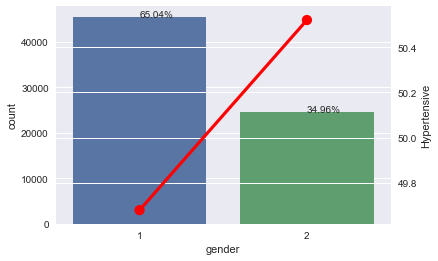

In [18]:
# Gender
fig,(ax) = plt.subplots(1,1)
tmp = pd.crosstab(data['gender'],data['cardio'],normalize='index').round(4)*100
tmp.reset_index()
tmp.columns = ['Not Hypertensive','Hypertensive']
ax1 = sns.countplot(data['gender'],order = list(tmp.index))
ax2 = ax1.twinx()
sns.pointplot(tmp.index,tmp['Hypertensive'],order = list(tmp.index),ax=ax2, color='red')
for x in ax1.patches:
    height = x.get_height()
    ax1.text(x.get_x()+x.get_width()/2,height,'{:.2f}{}'.format((height/len(data))*100,'%'))
plt.show()

Looks like men are more likely to have diseased then women.

In [19]:
# ap_hi
filt = (data['ap_hi']<90) | (data['ap_hi']>140)
print(f'Normal systolic blood pressure range is between 90 and 120. However, from our dataset we can see that we have {len(data[filt])} records that are not falling within the normal range. We can replace them with their median values.')

Normal systolic blood pressure range is between 90 and 120. However, from our dataset we can see that we have 10206 records that are not falling within the normal range. We can replace them with their median values.


In [20]:
data['ap_hi'].replace(data[filt]['ap_hi'].values,data['ap_hi'].median(),inplace=True)

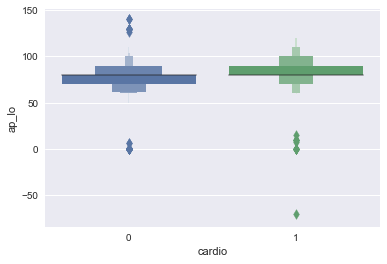

In [22]:
sns.boxenplot(data['cardio'],data['ap_lo'][data['ap_lo']<150])
plt.show()

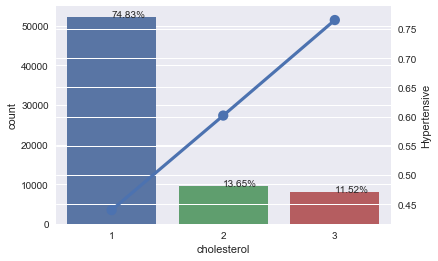

In [23]:
# cholesterol
tmp = pd.crosstab(data['cholesterol'],data['cardio'],normalize='index')
tmp.reset_index()
tmp.columns = ['not Hypertensive','Hypertensive']
fig, ax = plt.subplots(1,1)
sns.countplot(data['cholesterol'],order=list(tmp.index), ax=ax)
plot2 = ax.twinx()
sns.pointplot(tmp.index,tmp['Hypertensive'],order=list(tmp.index),ax=plot2)
for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x()+patch.get_width()/2,height,'{:.2f}{}'.format(height/len(data['cholesterol'])*100,'%'))
plt.show()



The above plot shows that cholesterol has a great impact over the diseased state of a person.

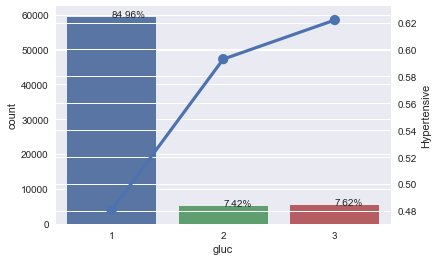

In [24]:
# Glucose
tmp = pd.crosstab(data['gluc'],data['cardio'],normalize='index')
tmp.reset_index()
tmp.columns = ['not Hypertensive','Hypertensive']
fig, ax = plt.subplots(1,1)
sns.countplot(data['gluc'],order=list(tmp.index), ax=ax)
plot2 = ax.twinx()
sns.pointplot(tmp.index,tmp['Hypertensive'],order=list(tmp.index),ax=plot2)
for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x()+patch.get_width()/2,height,'{:.2f}{}'.format(height/len(data['gluc'])*100,'%'))
plt.show()

Similar to cholesterol, a person with high glucose levels is also more prone to have Hypertension. Diabetic people BEWARE !

We would now combine the smoking and drinking habbits of a person into a single feature **'***smoke/drink***' **and study its impact.

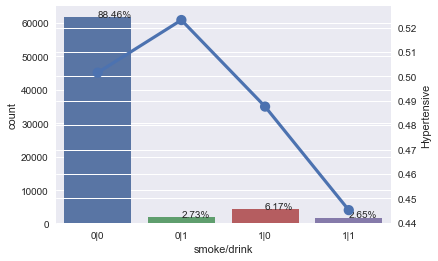

In [25]:
data['smoke/drink'] = data['smoke'].apply(str)+'|'+data['alco'].apply(str)

tmp = pd.crosstab(data['smoke/drink'],data['cardio'],normalize='index')
tmp.reset_index()
tmp.columns = ['Not Hypertensive','Hypertensive']

fig, ax = plt.subplots(1,1)
sns.countplot(data['smoke/drink'],order=list(tmp.index), ax=ax)
plot2 = ax.twinx()
sns.pointplot(tmp.index,tmp['Hypertensive'],order=list(tmp.index),ax=plot2)
for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x()+patch.get_width()/2,height,'{:.2f}{}'.format(height/len(data['smoke/drink'])*100,'%'))
plt.show()

Amongst all the people who dosen't smoke but drink seems to have the highest chances of having diseased. This seems a bit off from what the normal belief.

In [26]:
df_smoke_drink = pd.get_dummies(data['smoke/drink'],prefix='smoke/drink',drop_first=True)
data = pd.concat([data,df_smoke_drink],axis=1)
data.drop(['smoke/drink'],axis=1,inplace=True)
# data.head()

We would also now create a feature BMI using the height and weight of a person and see it's impact on target variable.

In [27]:
# BMI = weight(kg)/height(m2)
data['BMI'] = data['weight']/(((data['height']/0.0328084)*.01)**2)

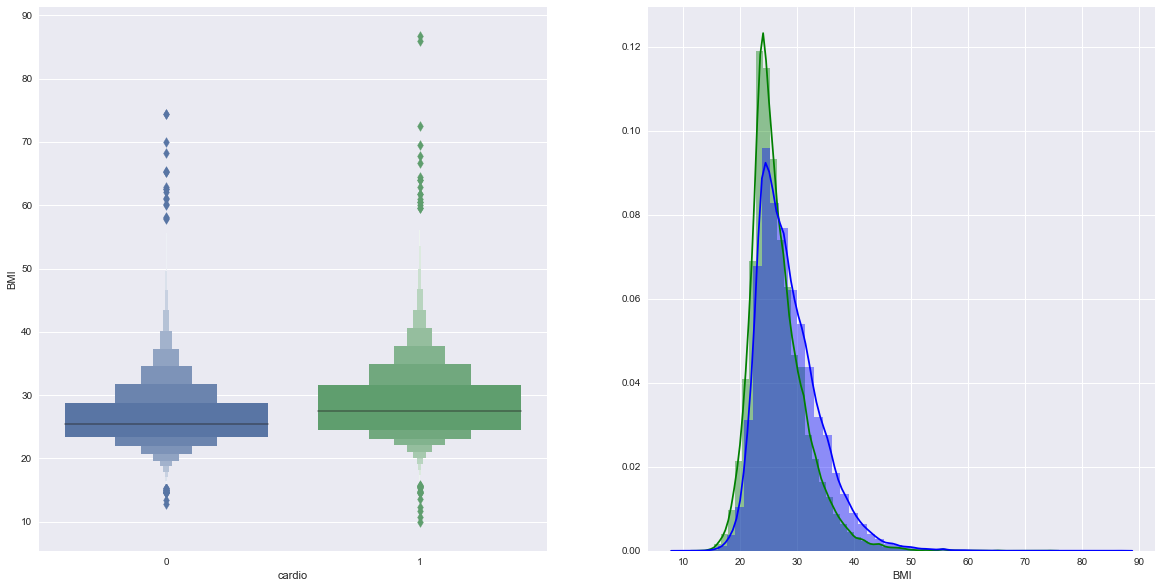

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
sns.boxenplot(data['cardio'],data['BMI'],ax=ax1)
sns.distplot(data[data['cardio']==0]['BMI'],color='g',ax=ax2)
sns.distplot(data[data['cardio']==1]['BMI'],color='b',ax=ax2)
plt.show()

# Modelling**

In [29]:
# The very first thing that we need to do is to break our data into training and test sets. 
from sklearn.model_selection import train_test_split
train,test = train_test_split(data, test_size = 0.25, random_state=42)
print (f'The shapes of our train & test data is {train.shape} and {test.shape} respectively.')

The shapes of our train & test data is (52445, 16) and (17482, 16) respectively.


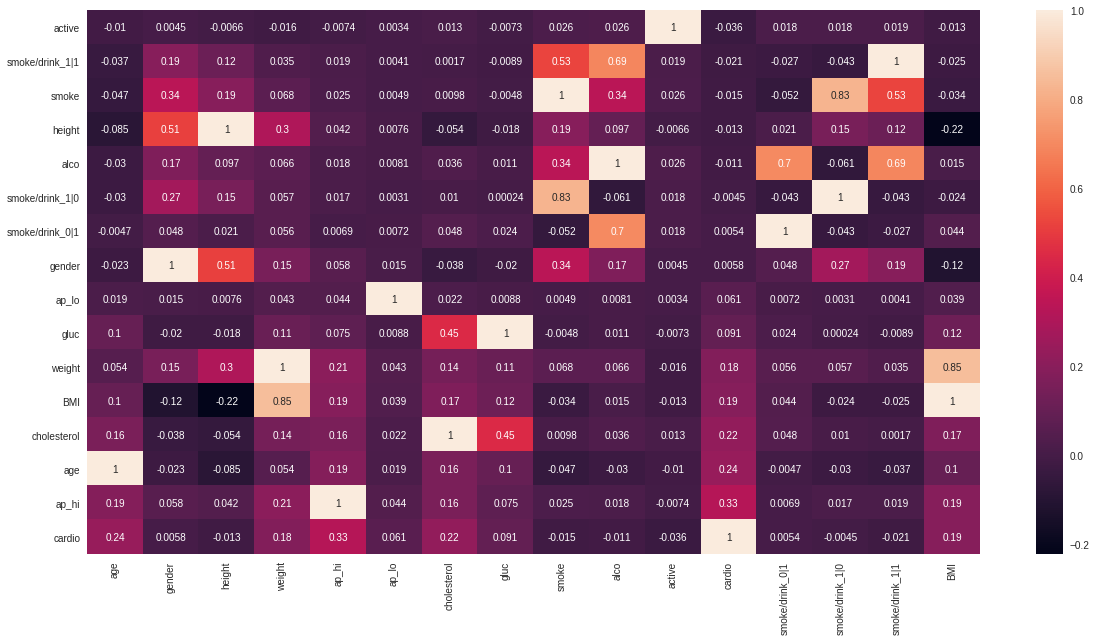

In [29]:
# Logistic Regression model assumes that there should be no multi-colinearity amongst the variables. 
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.heatmap(train.corr().sort_values(by='cardio'), annot=True)
plt.show()

1. Here we will be implementing Logistic Regression both in statsmodel and sklearn. Both of them have there own pros.


eg:- sklearn provides ease of implementation while the logistic regression gives us better model statistics 

In [30]:
# Logistic Regresssion - Selecting best penalty value for our Regularized model in scikit- learn

X = np.array(train.drop(['cardio','height','weight','gender','alco','smoke'], axis=1))
y = np.array(train['cardio'])
X_test = np.array(test.drop(['cardio','height','weight','gender','alco','smoke'], axis=1))
y_act = np.array(test['cardio'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=42)

from sklearn.linear_model import LogisticRegression
log_classifier = LogisticRegression()

from sklearn.model_selection import GridSearchCV
params = {'C':[0.001, 0.1,1,10,100,1000]}
grid = GridSearchCV(log_classifier, cv=kfold, param_grid=params)
grid.fit(X,y)
grid.best_params_

{'C': 10}

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix
log_classifier = LogisticRegression(C=10)

log_classifier.fit(X,y)
print(f'Train Score: {log_classifier.score(X,y)}')

y_pred = log_classifier.predict(X_test)
print(f'Test Score: {accuracy_score(y_act,y_pred)}')

Train Score: 0.6876918676708933
Test Score: 0.6856766960302025


In [32]:
# Statsmodel implementation.

import statsmodels.api as sm
x1 = sm.add_constant(X)
features = list(train.drop(['cardio','height','weight','gender','alco','smoke'],axis=1).columns)
features.insert(0,'const')
log_reg = sm.Logit(y,x1)
results = log_reg.fit()
results.summary(xname=features)

Optimization terminated successfully.
         Current function value: 0.595693
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                52445
Model:                          Logit   Df Residuals:                    52434
Method:                           MLE   Df Model:                           10
Date:                Fri, 10 Apr 2020   Pseudo R-squ.:                  0.1406
Time:                        07:40:49   Log-Likelihood:                -31241.
converged:                       True   LL-Null:                       -36352.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0057      0.010      0.589      0.556      -0.013       0.025
age                 0.3740      0.010     37.229      0.000       0.354       0.394
ap_hi               0.6298      0.011     56.353      0.000       0.608       0.652
ap_lo               0.2154      0.020     10.703      0.000       0.176       0.255
cholesterol         0.3774      0.012     32.121      0.000       0.354       0.400
gluc               -0.0673      0.011     -5.998      0.000      -0.089      -0.045
active             -0.0803      0.010     -8.335      0.000      -0.099      -0.061
smoke/drink_0|1    -0.0186      0.010     -1.896      0.058      -0.038       0.001
smoke/drink_1|0    -0.0108      0.010     -1.122      0.262      -0.030       0.008
smoke/drink_1|1    -0.0427      0.010     -4.392      0.000      -0.062      -0.024
BMI                 0.2409      0.010     23.456      0.000       0.221       0.261
===================================================================================
"""

In [33]:
print(f'Accuracy {(results.pred_table()[0][0]+results.pred_table()[1][1])/len(train)}')
print(f'{results.pred_table()}')

Accuracy 0.6876918676708933
[[18837.  7454.]
 [ 8925. 17229.]]


In [34]:
X_test = test.drop(['cardio','height','weight','gender','alco','smoke'], axis=1)
x1_test = sm.add_constant(X_test)
y_pred = results.predict(x1_test)

From the above we can see that we have received an overall accuracy of around 69% using our Logistic Regression model.

In [35]:
# Decision Tree Classifier

X = np.array(train.drop(['cardio'], axis=1))
y = np.array(train['cardio'])
X_test = np.array(test.drop(['cardio'], axis=1))
y_act = np.array(test['cardio'])

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini', random_state=42, max_depth=10)
dt.fit(X,y)
print(f'Train Accuracy for Decision Tree is : {dt.score(X,y)}')

Train Accuracy for Decision Tree is : 0.7401468204785966


In [36]:
print(f'Test Accuracy Score for Decision Tree is ; {accuracy_score(y_act,dt.predict(X_test))}')
confusion_matrix(y_act,dt.predict(X_test))

Test Accuracy Score for Decision Tree is ; 0.7167944171147466


array([[6581, 2110],
       [2841, 5950]])

In [37]:
# Support Vector Machines
X = np.array(train.drop(['cardio'],axis=1))
y = np.array(train['cardio'])
X_test = np.array(test.drop(['cardio'],axis=1))
y_act = test['cardio']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

from sklearn.svm import SVC
svc = SVC()

# params = {'C':[0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001]}
# grid = GridSearchCV(svc, param_grid=params)
# grid.fit(X,y)
# grid.best_params_

svc.fit(X,y)
print(f'Train Score: {svc.score(X,y)}')


y_pred = svc.predict(X_test)
print(f'Test Score: {accuracy_score(y_act,y_pred)}')

Train Score: 0.6883210982934502
Test Score: 0.6839034435419289


In [38]:
# Naive Bayes Classifier
X = np.array(train.drop(['cardio'],axis=1))
y = np.array(train['cardio'])
X_test = np.array(test.drop(['cardio'],axis=1))
y_act = test['cardio']

from sklearn.naive_bayes import GaussianNB
gb = GaussianNB()
gb.fit(X,y)
print(f'Train Score: {gb.score(X,y)}')


y_pred = gb.predict(X_test)
print(f'Test Score: {accuracy_score(y_act,y_pred)}')



Train Score: 0.6537515492420631
Test Score: 0.6527285207642146


## Ensemble Methods

In [39]:
# Random Forest

X = np.array(train.drop(['cardio'], axis=1))
y = np.array(train['cardio'])
X_test = np.array(test.drop(['cardio'], axis=1))
y_act = np.array(test['cardio'])

from sklearn.ensemble import RandomForestClassifier
param = {'n_estimators': [10, 20, 40, 80, 160, 300], 'random_state': [42], 'criterion': ['gini'], 'max_depth': [2, 4, 8, 16, 32]}
rf = RandomForestClassifier()
grid = GridSearchCV(rf,param)
grid.fit(X,y)
grid.best_params_


{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 40, 'random_state': 42}

In [40]:
rf_upd = RandomForestClassifier(n_estimators=40, criterion='gini', max_depth=8, random_state=42)
rf_upd.fit(X,y)
print(f'Train Score: {rf_upd.score(X,y)}')

y_pred = rf_upd.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_act,y_pred)}')

Train Score: 0.7300409953284394
Test Accuracy: 0.7171376272737673


In [41]:
Feature_importances = pd.concat([pd.Series(test.drop(['cardio','ap_lo'], axis=1).columns),pd.Series(rf_upd.feature_importances_)],axis=1).sort_values(by=1, ascending=False)
Feature_importances.columns = ['Feature','Weights']
Feature_importances

,Feature,Weights
5,cholesterol,0.359153
4,ap_hi,0.257114
0,age,0.142526
6,gluc,0.103672
3,weight,0.052342
14,NaN,0.049965
2,height,0.012397
7,smoke,0.009135
10,smoke/drink_0|1,0.004153
8,alco,0.002551


In [42]:
# Gradient Boosting 
X = np.array(train.drop(['cardio'],axis=1))
y = np.array(train['cardio'])
X_test = np.array(test.drop(['cardio'],axis=1))
y_act = test['cardio']

from  xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X,y)
print(f'Train Score: {xgb.score(X,y)}')

y_pred = xgb.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_act,y_pred)}')

Train Score: 0.7605110115358947
Test Accuracy: 0.7142775426152614


## Deep Learning 

In [43]:
# ANN
import tensorflow as tf
import keras as ks
from keras.models import Sequential
from keras.layers import Dense

X = np.array(train.drop(['cardio'],axis=1))
y = np.array(train['cardio'])
X_test = np.array(test.drop(['cardio'],axis=1))
y_act = test['cardio']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)

classifier = Sequential()


classifier.add(Dense(8, input_shape=(15,), activation = 'relu'))
classifier.add(Dense(8, activation = 'relu'))

classifier.add(Dense(1, activation = 'sigmoid'))

classifier.compile('adam',loss='binary_crossentropy', metrics=['accuracy'])

classifier.fit(X,y, batch_size= 10, epochs = 100)

Using TensorFlow backend.


Epoch 1/100
52445/52445 [==============================] - 8s 145us/step - loss: 0.6023 - accuracy: 0.6787
Epoch 2/100
52445/52445 [==============================] - 7s 136us/step - loss: 0.5881 - accuracy: 0.6921
Epoch 3/100
52445/52445 [==============================] - 7s 134us/step - loss: 0.5836 - accuracy: 0.6987
Epoch 4/100
52445/52445 [==============================] - 7s 139us/step - loss: 0.5788 - accuracy: 0.7051
Epoch 5/100
52445/52445 [==============================] - 7s 135us/step - loss: 0.5755 - accuracy: 0.7082
Epoch 6/100
52445/52445 [==============================] - 7s 135us/step - loss: 0.5727 - accuracy: 0.7115
Epoch 7/100
52445/52445 [==============================] - 7s 140us/step - loss: 0.5709 - accuracy: 0.7131
Epoch 8/100
52445/52445 [==============================] - 7s 136us/step - loss: 0.5694 - accuracy: 0.7141
Epoch 9/100
52445/52445 [==============================] - 7s 136us/step - loss: 0.5680 - accuracy: 0.7148
Epoch 10/100
52445/52445 [===========

In [44]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred >= 0.5)
print(f'Test Accuracy for Deep Learning: {accuracy_score(y_act,y_pred)}')

Test Accuracy for Deep Learning: 0.7152499713991534


The max accuracy that we have achieved by running our deep learning model with default parameters and running for 100 epochs is 71.52% on test data.